
# Projeto: Análise de Desempenho em Provas de Python com IA

**Disciplina:** Modelagem e estatistica  
**Autor:** _Deivison Ryan Brito Tavares & Carlos Eduardo Ferreira Texeira_  
**Dataset:** Python Learning & Exam Performance Dataset (Kaggle)  

---

## 1. Introdução e Objetivos

Este projeto tem como objetivo colocar em prática as seguintes habilidades:

1. **Análise exploratória de dados (EDA)** com limpeza, tratamento de valores ausentes e investigação das relações entre variáveis independentes e dependentes;
2. **Implementação e comparação** de algoritmos de IA para:
   - Regressão: regressão linear simples, múltipla e polinomial;
   - Classificação: Naive Bayes e Regressão Logística;
3. **Avaliação de desempenho** com métricas apropriadas para regressão e classificação;
4. **Otimização de modelos** usando validação cruzada e *tuning* de hiperparâmetros (PyCaret e `sklearn`), discutindo ganhos e limitações.

Ferramentas obrigatórias utilizadas neste notebook:

- `pandas`
- `seaborn`
- `statsmodels`
- `scikit-learn`
- `pycaret`

### 1.1. Problema de negócio

O conjunto de dados contém informações sobre **estudantes aprendendo Python**
(idade, país, experiência prévia, hábitos de estudo, participação em fóruns, etc.)
e seus **resultados em uma prova final**.

Definiremos dois problemas de modelagem:

- **Regressão:** prever a **nota da prova final** (`final_exam_score`);
- **Classificação:** prever se o estudante **foi aprovado** na prova (`passed_exam`).

### 1.2. Hipóteses de negócio

Algumas hipóteses que iremos investigar:

1. Estudantes que **resolvem mais exercícios práticos** e **fazem mais projetos** tendem a obter **notas mais altas**.
2. Participar de **fóruns de discussão** e usar **Kaggle** está associado a melhor desempenho.
3. Estudantes com **maior experiência prévia em programação** atingem melhores resultados no exame de Python.


In [2]:
pip install pandas numpy seaborn matplotlib statsmodels scikit-learn pycaret jupyter scipy


  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl (11.3 MB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached matplotlib-3.10.8-cp310-cp310-win_amd64.whl (8.1 MB)
  Using cached statsmodels-0.14.6-cp310-cp310-win_amd64.whl (9.6 MB)
  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
  Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl (41.3 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.61.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl (73 kB)
  Using cached pillow-12.0.0-cp310-cp310-win_amd64.whl (7.0 MB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
 

You should consider upgrading via the 'c:\teste1231231\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB

from scipy import stats

# PyCaret
from pycaret.regression import (
    setup as reg_setup,
    compare_models as reg_compare,
    tune_model as reg_tune,
    pull as reg_pull
)
from pycaret.classification import (
    setup as cls_setup,
    compare_models as cls_compare,
    tune_model as cls_tune,
    pull as cls_pull
)

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", palette="muted", font_scale=1.0)
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 2. Dados: Fonte, Licença e Carregamento

- **Nome:** Python Learning & Exam Performance Dataset  
- **Autor:** Emon Sarkar  
- **Plataforma:** Kaggle  
- **Link:** https://www.kaggle.com/datasets/emonsharkar/python-learning-and-exam-performance-dataset  

> Consulte a licença na página do dataset (seção *License*) antes de uso público.

Coloque o arquivo CSV em `data/python_learning_exam_performance.csv` ou na raiz do projeto.


In [4]:

# Carregamento do CSV
possible_paths = [
    "data/python_learning_exam_performance.csv",
    "python_learning_exam_performance.csv",
]

df = None
for p in possible_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Arquivo carregado de: {p}")
        break

if df is None:
    raise FileNotFoundError(
        "Não foi possível encontrar 'python_learning_exam_performance.csv'. "
        "Coloque o arquivo na raiz do projeto ou em 'data/'."
    )

df.head()


Arquivo carregado de: python_learning_exam_performance.csv


,student_id,age,country,prior_programming_experience,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam
0,1,54,Pakistan,Beginner,12,12.2,60,1,24,0,1,4,10,53.8,0
1,2,44,Nigeria,NaN,15,14.2,52,1,32,0,0,5,7,31.9,0
2,3,30,India,Intermediate,5,7.7,71,1,43,0,0,6,3,59.4,0
3,4,23,Nigeria,Beginner,4,5.6,64,2,40,1,0,3,10,58.8,0
4,5,36,UK,NaN,3,3.5,62,1,47,1,0,3,7,24.8,0


In [5]:

# Teste simples de schema
expected_columns = {
    "student_id", "age", "country", "prior_programming_experience",
    "weeks_in_course", "hours_spent_learning_per_week",
    "practice_problems_solved", "projects_completed",
    "tutorial_videos_watched", "uses_kaggle",
    "participates_in_discussion_forums", "debugging_sessions_per_week",
    "self_reported_confidence_python", "final_exam_score", "passed_exam"
}

missing_cols = expected_columns.difference(df.columns)
extra_cols = set(df.columns).difference(expected_columns)

print("Colunas faltantes:", missing_cols)
print("Colunas extras:", extra_cols)

assert len(missing_cols) == 0, "O dataset não contém todas as colunas esperadas."
print("✅ Teste de schema básico passou.")


Colunas faltantes: set()
Colunas extras: set()
✅ Teste de schema básico passou.


## 3. EDA — Análise Exploratória de Dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   student_id                         3000 non-null   int64  
 1   age                                3000 non-null   int64  
 2   country                            3000 non-null   object 
 3   prior_programming_experience       1938 non-null   object 
 4   weeks_in_course                    3000 non-null   int64  
 5   hours_spent_learning_per_week      3000 non-null   float64
 6   practice_problems_solved           3000 non-null   int64  
 7   projects_completed                 3000 non-null   int64  
 8   tutorial_videos_watched            3000 non-null   int64  
 9   uses_kaggle                        3000 non-null   int64  
 10  participates_in_discussion_forums  3000 non-null   int64  
 11  debugging_sessions_per_week        3000 non-null   int64

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
student_id,3000.0,NaN,NaN,NaN,1500.5,866.169729,1.0,750.75,1500.5,2250.25,3000.0
age,3000.0,NaN,NaN,NaN,35.327,11.302182,16.0,26.0,36.0,45.0,54.0
country,3000,10,Brazil,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prior_programming_experience,1938,3,Beginner,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weeks_in_course,3000.0,NaN,NaN,NaN,8.121,4.275019,1.0,5.0,8.0,12.0,15.0
hours_spent_learning_per_week,3000.0,NaN,NaN,NaN,7.035267,2.936134,0.0,5.0,7.0,9.0,17.1
practice_problems_solved,3000.0,NaN,NaN,NaN,59.983667,7.713056,35.0,55.0,60.0,65.0,87.0
projects_completed,3000.0,NaN,NaN,NaN,2.001333,1.395701,0.0,1.0,2.0,3.0,9.0
tutorial_videos_watched,3000.0,NaN,NaN,NaN,39.896667,6.263258,19.0,35.0,40.0,44.0,63.0
uses_kaggle,3000.0,NaN,NaN,NaN,0.400667,0.490115,0.0,0.0,0.0,1.0,1.0


In [8]:

# Valores ausentes
df.isna().sum()


student_id                              0
age                                     0
country                                 0
prior_programming_experience         1062
weeks_in_course                         0
hours_spent_learning_per_week           0
practice_problems_solved                0
projects_completed                      0
tutorial_videos_watched                 0
uses_kaggle                             0
participates_in_discussion_forums       0
debugging_sessions_per_week             0
self_reported_confidence_python         0
final_exam_score                        0
passed_exam                             0
dtype: int64

In [9]:

# Tratamento simples de ausentes
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

df.isna().sum()


student_id                           0
age                                  0
country                              0
prior_programming_experience         0
weeks_in_course                      0
hours_spent_learning_per_week        0
practice_problems_solved             0
projects_completed                   0
tutorial_videos_watched              0
uses_kaggle                          0
participates_in_discussion_forums    0
debugging_sessions_per_week          0
self_reported_confidence_python      0
final_exam_score                     0
passed_exam                          0
dtype: int64

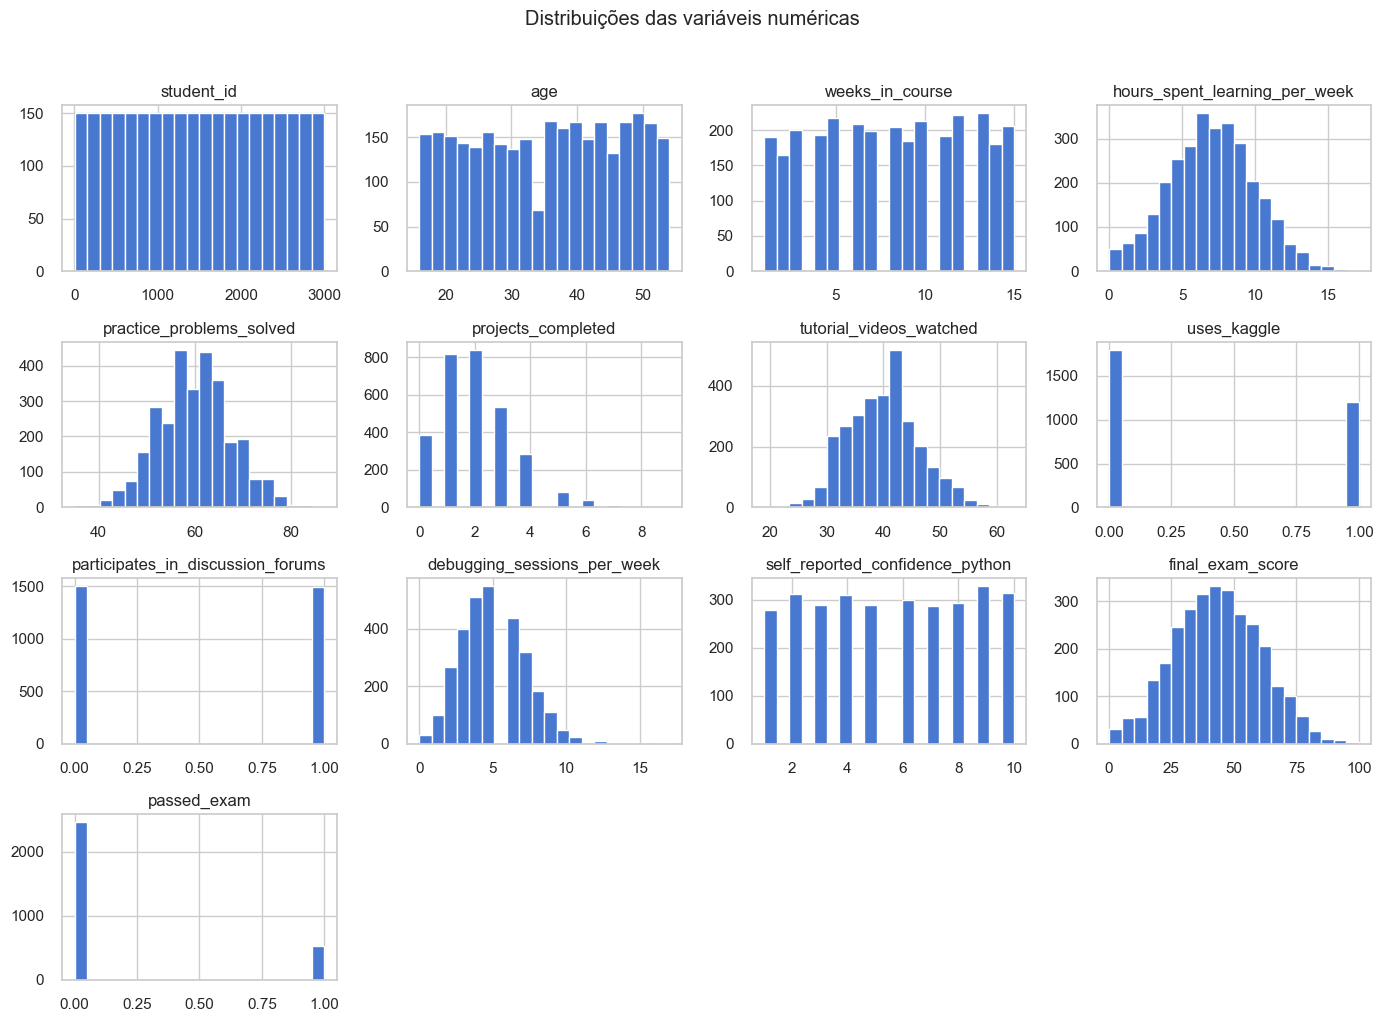

In [10]:

# Histogramas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[numeric_cols].hist(figsize=(14, 10), bins=20)
plt.suptitle("Distribuições das variáveis numéricas", y=1.02)
plt.tight_layout()
plt.show()


Observa-se que estudantes com experiência intermediária ou avançada apresentam distribuições de notas mais elevadas e menos dispersas, sugerindo maior consistência no aprendizado. Já os iniciantes têm maior variabilidade e tendência a notas mais baixas, o que indica que a falta de base prévia pode dificultar o acompanhamento do curso. Esse comportamento reforça o resultado do teste ANOVA, que indicou diferença estatisticamente significativa entre os grupos.

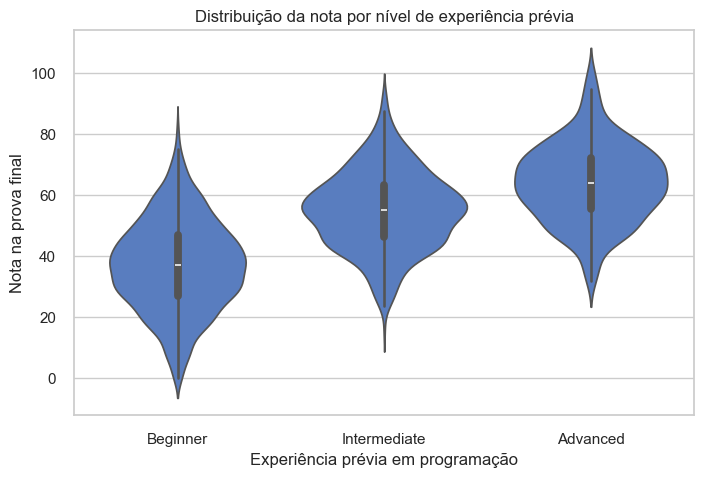

In [44]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x="prior_programming_experience",
    y="final_exam_score",
    inner="box"
)
plt.title("Distribuição da nota por nível de experiência prévia")
plt.xlabel("Experiência prévia em programação")
plt.ylabel("Nota na prova final")
plt.show()


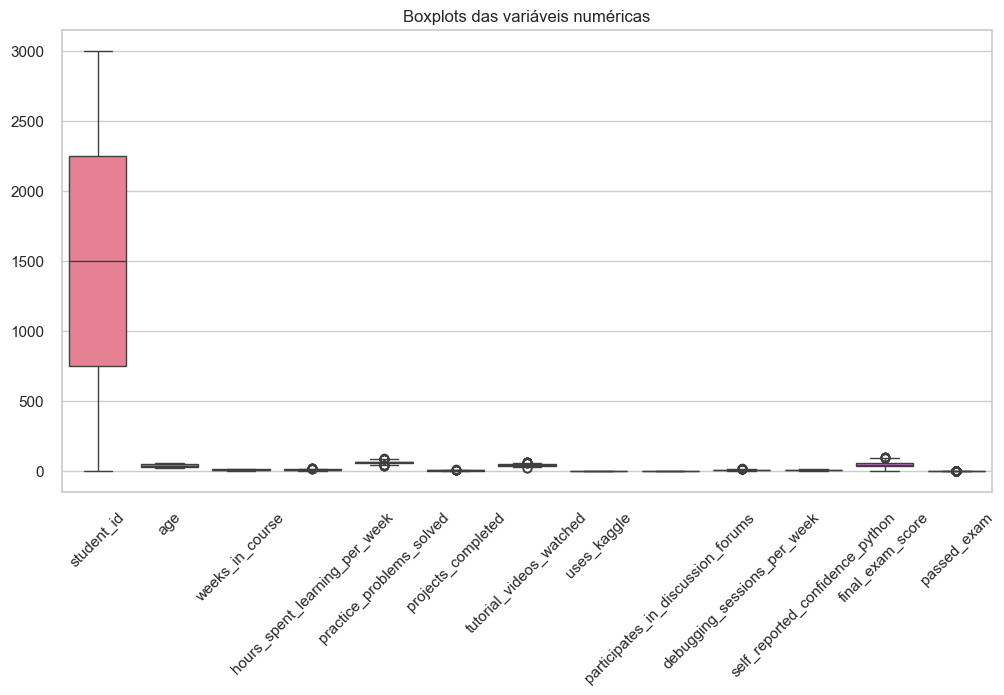

In [11]:

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
plt.title("Boxplots das variáveis numéricas")
plt.show()


Estudantes que utilizam o Kaggle obtêm, em média, notas superiores. Isso sugere que a prática por meio de desafios, kernels e competições contribui para consolidar conceitos e melhorar o desempenho no exame final. Embora não prove causalidade, a diferença consistente indica que o engajamento em plataformas externas de prática pode ser um fator relevante para o aprendizado.

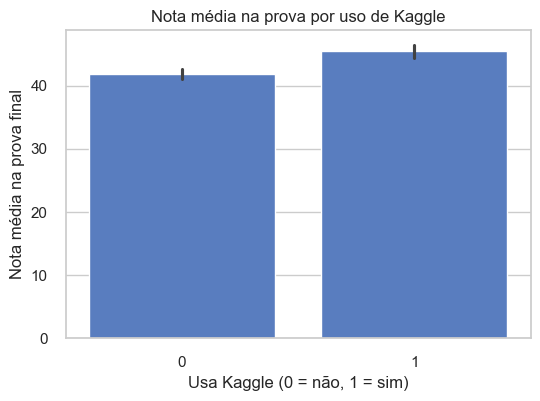

In [45]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df,
    x="uses_kaggle",
    y="final_exam_score",
    estimator=np.mean,
    ci=95
)
plt.title("Nota média na prova por uso de Kaggle")
plt.xlabel("Usa Kaggle (0 = não, 1 = sim)")
plt.ylabel("Nota média na prova final")
plt.show()


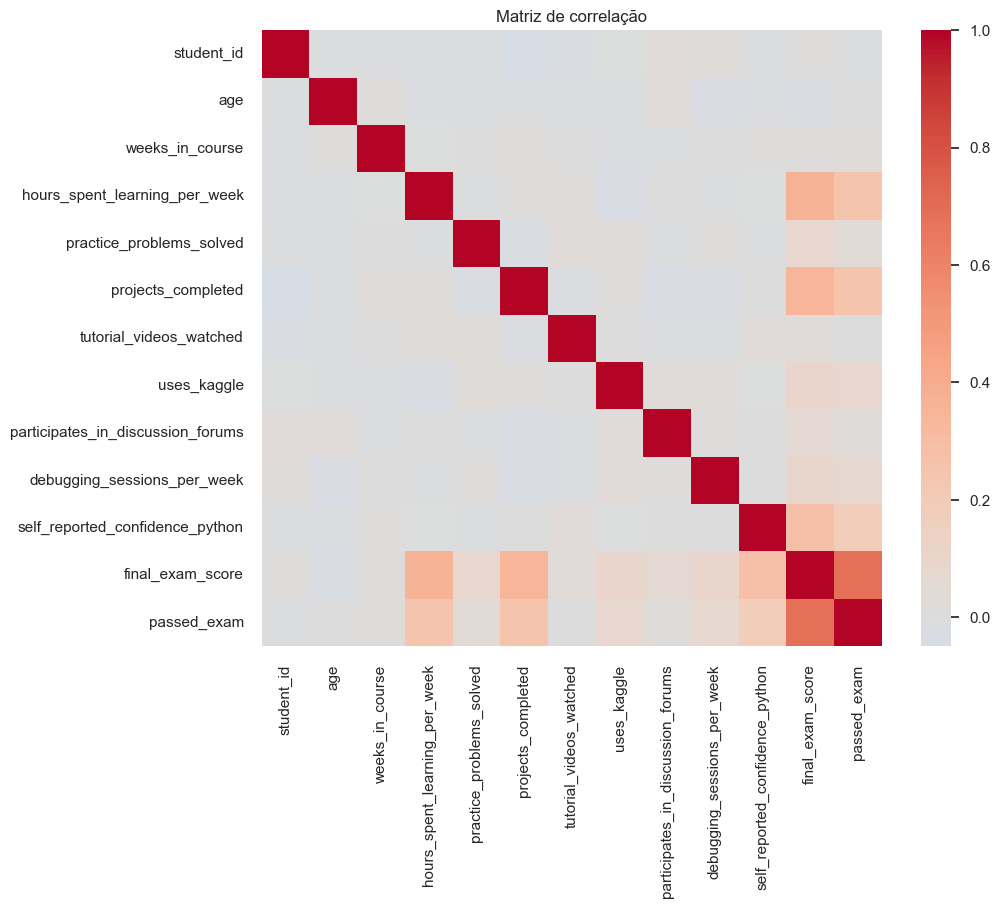

In [12]:

# Heatmap de correlação
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de correlação")
plt.show()


Existe uma relação positiva clara entre horas semanais de estudo e nota final. A linha de tendência indica que o desempenho aumenta conforme o aluno dedica mais tempo à prática e ao estudo dirigido. Esse comportamento justifica o uso de regressão linear simples nessa variável, que apresenta relação aproximadamente linear e significativa com o score final.

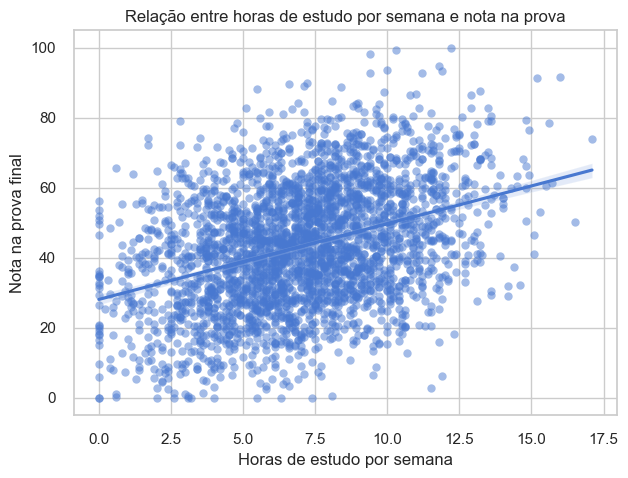

In [46]:
plt.figure(figsize=(7, 5))
sns.regplot(
    data=df,
    x="hours_spent_learning_per_week",
    y="final_exam_score",
    scatter_kws={"alpha": 0.5}
)
plt.title("Relação entre horas de estudo por semana e nota na prova")
plt.xlabel("Horas de estudo por semana")
plt.ylabel("Nota na prova final")
plt.show()


A taxa de aprovação é visivelmente maior entre estudantes com experiência intermediária e avançada. O grupo iniciante concentra a maior parte das reprovações, reforçando a hipótese de que a base técnica prévia influencia de forma relevante a probabilidade de sucesso no curso. Esse padrão também sugere que políticas de nivelamento ou módulos preparatórios podem reduzir desigualdades de desempenho.

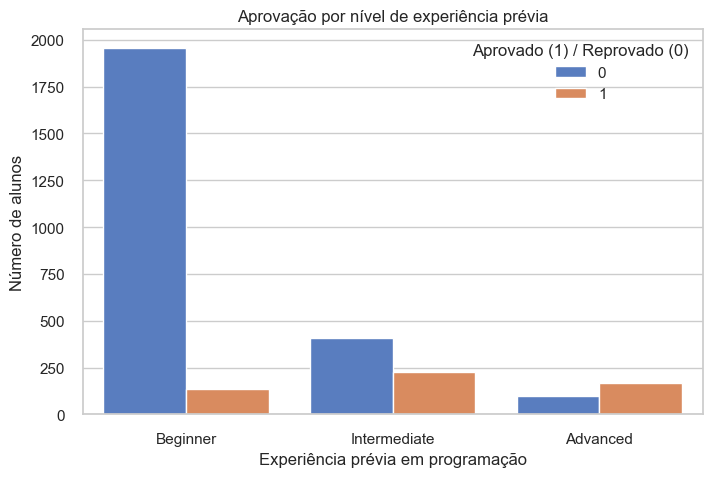

In [47]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x="prior_programming_experience",
    hue="passed_exam"
)
plt.title("Aprovação por nível de experiência prévia")
plt.xlabel("Experiência prévia em programação")
plt.ylabel("Número de alunos")
plt.legend(title="Aprovado (1) / Reprovado (0)")
plt.show()


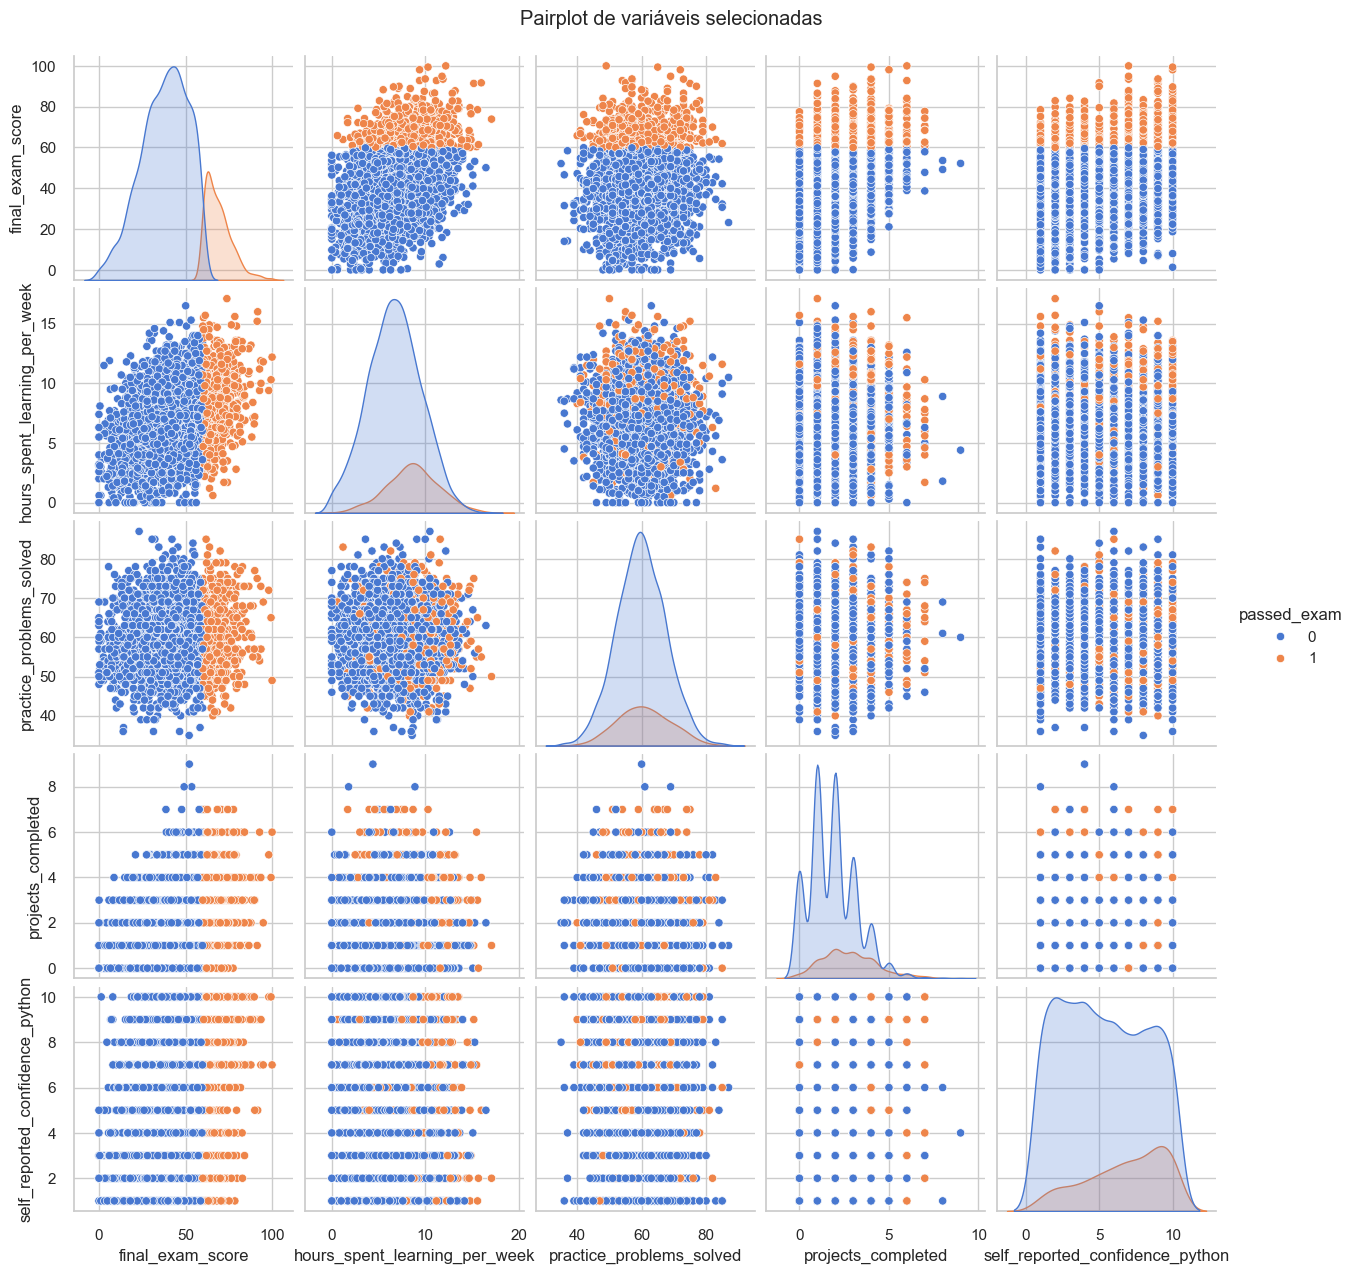

In [13]:

# Pairplot
subset_cols = [
    "final_exam_score",
    "passed_exam",
    "hours_spent_learning_per_week",
    "practice_problems_solved",
    "projects_completed",
    "self_reported_confidence_python"
]

sns.pairplot(df[subset_cols], hue="passed_exam", diag_kind="kde")
plt.suptitle("Pairplot de variáveis selecionadas", y=1.02)
plt.show()


In [14]:

# Testes estatísticos
pearson_r, pearson_p = stats.pearsonr(
    df["hours_spent_learning_per_week"],
    df["final_exam_score"]
)
print(f"Correlação de Pearson (horas x nota): r={pearson_r:.3f}, p-valor={pearson_p:.3e}")

groups = [
    g["final_exam_score"].values
    for _, g in df.groupby("prior_programming_experience")
]
anova_F, anova_p = stats.f_oneway(*groups)
print(f"ANOVA (nota ~ experiência prévia): F={anova_F:.3f}, p-valor={anova_p:.3e}")

contingency = pd.crosstab(df["uses_kaggle"], df["passed_exam"])
chi2, chi_p, dof, expected = stats.chi2_contingency(contingency)
print("Qui-quadrado (uses_kaggle x passed_exam):")
print(f"chi2={chi2:.3f}, dof={dof}, p-valor={chi_p:.3e}")
contingency


Correlação de Pearson (horas x nota): r=0.365, p-valor=2.286e-95
ANOVA (nota ~ experiência prévia): F=698.959, p-valor=7.135e-250
Qui-quadrado (uses_kaggle x passed_exam):
chi2=17.877, dof=1, p-valor=2.356e-05


passed_exam,0,1
uses_kaggle,,
0,1523,275
1,945,257


In [15]:

# Outliers via IQR
q1 = df["final_exam_score"].quantile(0.25)
q3 = df["final_exam_score"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["final_exam_score"] < lower_bound) | (df["final_exam_score"] > upper_bound)]
print(f"Número de possíveis outliers em 'final_exam_score': {len(outliers)}")


Número de possíveis outliers em 'final_exam_score': 8


## 4. Preparação para Modelagem

In [16]:

# One-hot e splits
df_model = df.drop(columns=["student_id"])
df_model = pd.get_dummies(df_model, drop_first=True)

target_reg = "final_exam_score"
target_cls = "passed_exam"

X = df_model.drop(columns=[target_reg, target_cls])
y_reg = df_model[target_reg]
y_cls = df_model[target_cls]

X_temp, X_test, y_reg_temp, y_reg_test, y_cls_temp, y_cls_test = train_test_split(
    X, y_reg, y_cls, test_size=0.3, random_state=42
)

X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val = train_test_split(
    X_temp, y_reg_temp, y_cls_temp, test_size=0.3, random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((1470, 21), (630, 21), (900, 21))

In [17]:

# Baseline Regressão
y_reg_mean = y_reg_train.mean()
y_reg_pred_baseline_val = np.repeat(y_reg_mean, len(y_reg_val))

baseline_reg_mae = mean_absolute_error(y_reg_val, y_reg_pred_baseline_val)
baseline_reg_rmse = mean_squared_error(y_reg_val, y_reg_pred_baseline_val, squared=False)
baseline_reg_r2 = r2_score(y_reg_val, y_reg_pred_baseline_val)

print("Baseline regressão (média do treino):")
print(f"MAE  = {baseline_reg_mae:.3f}")
print(f"RMSE = {baseline_reg_rmse:.3f}")
print(f"R^2  = {baseline_reg_r2:.3f}")


Baseline regressão (média do treino):
MAE  = 14.016
RMSE = 17.580
R^2  = -0.000


In [18]:

# Baseline Classificação
majority_class = y_cls_train.mode()[0]
y_cls_pred_baseline_val = np.repeat(majority_class, len(y_cls_val))

baseline_cls_acc = accuracy_score(y_cls_val, y_cls_pred_baseline_val)
print("Baseline classificação (classe majoritária):")
print(f"Acurácia = {baseline_cls_acc:.3f}")
print(f"Classe majoritária (treino) = {majority_class}")


Baseline classificação (classe majoritária):
Acurácia = 0.817
Classe majoritária (treino) = 0


## 5. Modelagem de Regressão

In [19]:

# Regressão Linear Simples (statsmodels)
df_reg = df_model.copy()

model_simple = smf.ols(
    formula="final_exam_score ~ hours_spent_learning_per_week",
    data=df_reg
).fit()

print(model_simple.summary())


                            OLS Regression Results                            
Dep. Variable:       final_exam_score   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     461.7
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.29e-95
Time:                        23:33:47   Log-Likelihood:                -12607.
No. Observations:                3000   AIC:                         2.522e+04
Df Residuals:                    2998   BIC:                         2.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [20]:

# Regressão Linear Múltipla (statsmodels)
predictors = [
    "age",
    "weeks_in_course",
    "hours_spent_learning_per_week",
    "practice_problems_solved",
    "projects_completed",
    "tutorial_videos_watched",
    "debugging_sessions_per_week",
    "self_reported_confidence_python"
]

dummies_cols = [
    c for c in df_reg.columns
    if "prior_programming_experience_" in c or "country_" in c
]
predictors += dummies_cols

formula_mult = "final_exam_score ~ " + " + ".join(predictors)

model_mult = smf.ols(formula=formula_mult, data=df_reg).fit()
print(model_mult.summary())


                            OLS Regression Results                            
Dep. Variable:       final_exam_score   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     306.5
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:33:47   Log-Likelihood:                -11197.
No. Observations:                3000   AIC:                         2.243e+04
Df Residuals:                    2980   BIC:                         2.255e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Seleciona as colunas do modelo
X_vif = df_reg[predictors].copy()

# 2) Converte bool explicitamente pra int
bool_cols = X_vif.select_dtypes(include=["bool"]).columns
X_vif[bool_cols] = X_vif[bool_cols].astype(int)

# 3) Garante tudo numérico (se tiver algo estranho vira NaN)
X_vif = X_vif.apply(pd.to_numeric, errors='coerce')

# 4) Tira inf/NaN que possam sobrar
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()

# 5) Adiciona constante
X_vif_const = sm.add_constant(X_vif)

# 6) Converte o DataFrame para um array 100% float
X_vals = X_vif_const.to_numpy(dtype=float)

# 7) Calcula VIF
vifs = pd.DataFrame({
    "feature": X_vif_const.columns,
    "VIF": [
        variance_inflation_factor(X_vals, i)
        for i in range(X_vals.shape[1])
    ]
})

# Se não quiser ver a constante:
vifs[vifs["feature"] != "const"]


,feature,VIF
1,age,1.005316
2,weeks_in_course,1.003938
3,hours_spent_learning_per_week,1.003870
4,practice_problems_solved,1.007824
5,projects_completed,1.006829
6,tutorial_videos_watched,1.006004
7,debugging_sessions_per_week,1.006429
8,self_reported_confidence_python,1.007885
9,country_Brazil,1.949601
10,country_Germany,1.894166


In [26]:

# Regressão Polinomial (sklearn)
poly_features = ["hours_spent_learning_per_week"]

X_poly_train = X_train[poly_features]
X_poly_val = X_val[poly_features]

poly_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

poly_pipeline.fit(X_poly_train, y_reg_train)
y_reg_pred_poly_val = poly_pipeline.predict(X_poly_val)

mae_poly = mean_absolute_error(y_reg_val, y_reg_pred_poly_val)
rmse_poly = mean_squared_error(y_reg_val, y_reg_pred_poly_val, squared=False)
r2_poly = r2_score(y_reg_val, y_reg_pred_poly_val)

print("Desempenho Regressão Polinomial (validação):")
print(f"MAE  = {mae_poly:.3f}")
print(f"RMSE = {rmse_poly:.3f}")
print(f"R^2  = {r2_poly:.3f}")


Desempenho Regressão Polinomial (validação):
MAE  = 13.015
RMSE = 16.028
R^2  = 0.169


In [27]:

# Regressão Linear (sklearn) + resíduos
reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

reg_pipeline.fit(X_train, y_reg_train)
y_reg_pred_val = reg_pipeline.predict(X_val)

reg_mae = mean_absolute_error(y_reg_val, y_reg_pred_val)
reg_rmse = mean_squared_error(y_reg_val, y_reg_pred_val, squared=False)
reg_r2 = r2_score(y_reg_val, y_reg_pred_val)

print("Desempenho Regressão (Linear Múltipla - sklearn) - Validação:")
print(f"MAE  = {reg_mae:.3f}")
print(f"RMSE = {reg_rmse:.3f}")
print(f"R^2  = {reg_r2:.3f}")


Desempenho Regressão (Linear Múltipla - sklearn) - Validação:
MAE  = 8.297
RMSE = 10.317
R^2  = 0.656


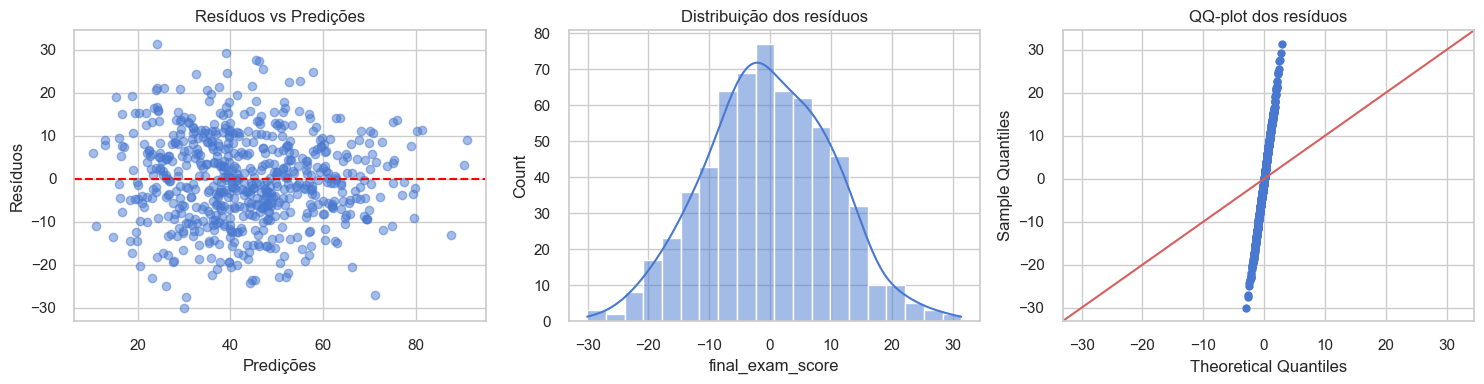

Shapiro-Wilk: stat=0.999, p-valor=9.449e-01
Breusch-Pagan: stat=8.712, p-valor=3.161e-03


In [28]:

# Diagnóstico de resíduos
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

residuals = y_reg_val - y_reg_pred_val

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(y_reg_pred_val, residuals, alpha=0.5)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predições")
axes[0].set_ylabel("Resíduos")
axes[0].set_title("Resíduos vs Predições")

sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Distribuição dos resíduos")

sm.qqplot(residuals, line="45", ax=axes[2])
axes[2].set_title("QQ-plot dos resíduos")

plt.tight_layout()
plt.show()

shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk: stat={shapiro_stat:.3f}, p-valor={shapiro_p:.3e}")

bp_test = het_breuschpagan(residuals, sm.add_constant(y_reg_pred_val))
bp_stat, bp_pvalue = bp_test[0], bp_test[1]
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p-valor={bp_pvalue:.3e}")


## 6. Modelagem de Classificação

In [29]:

def classification_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    return acc, prec, rec, f1, auc


In [30]:

# Naive Bayes
nb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("nb", GaussianNB())
])

nb_pipeline.fit(X_train, y_cls_train)
y_nb_val_proba = nb_pipeline.predict_proba(X_val)[:, 1]
y_nb_val_pred = (y_nb_val_proba >= 0.5).astype(int)

acc_nb, prec_nb, rec_nb, f1_nb, auc_nb = classification_metrics(
    y_cls_val, y_nb_val_pred, y_nb_val_proba
)

print("Naive Bayes (Validação):")
print(f"Acurácia  = {acc_nb:.3f}")
print(f"Precisão  = {prec_nb:.3f}")
print(f"Recall    = {rec_nb:.3f}")
print(f"F1        = {f1_nb:.3f}")
print(f"AUC-ROC   = {auc_nb:.3f}")


Naive Bayes (Validação):
Acurácia  = 0.813
Precisão  = 0.488
Recall    = 0.530
F1        = 0.508
AUC-ROC   = 0.838


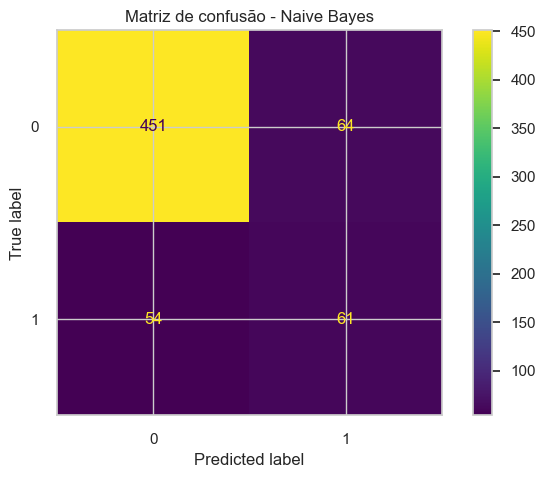

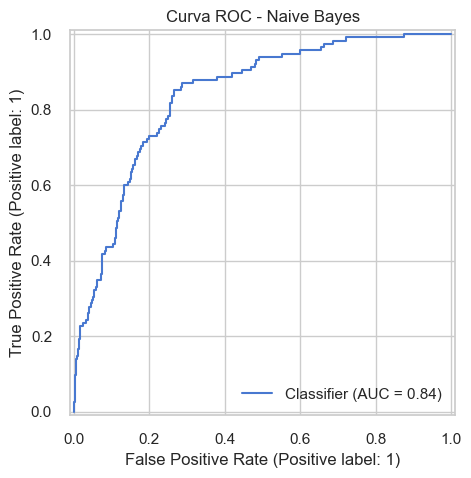

In [31]:

cm_nb = confusion_matrix(y_cls_val, y_nb_val_pred)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb)
disp_nb.plot(values_format="d")
plt.title("Matriz de confusão - Naive Bayes")
plt.show()

RocCurveDisplay.from_predictions(y_cls_val, y_nb_val_proba)
plt.title("Curva ROC - Naive Bayes")
plt.show()


In [32]:

# Regressão Logística
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_cls_train)
y_log_val_proba = logreg_pipeline.predict_proba(X_val)[:, 1]
y_log_val_pred = (y_log_val_proba >= 0.5).astype(int)

acc_log, prec_log, rec_log, f1_log, auc_log = classification_metrics(
    y_cls_val, y_log_val_pred, y_log_val_proba
)

print("Regressão Logística (Validação):")
print(f"Acurácia  = {acc_log:.3f}")
print(f"Precisão  = {prec_log:.3f}")
print(f"Recall    = {rec_log:.3f}")
print(f"F1        = {f1_log:.3f}")
print(f"AUC-ROC   = {auc_log:.3f}")


Regressão Logística (Validação):
Acurácia  = 0.906
Precisão  = 0.792
Recall    = 0.661
F1        = 0.720
AUC-ROC   = 0.938


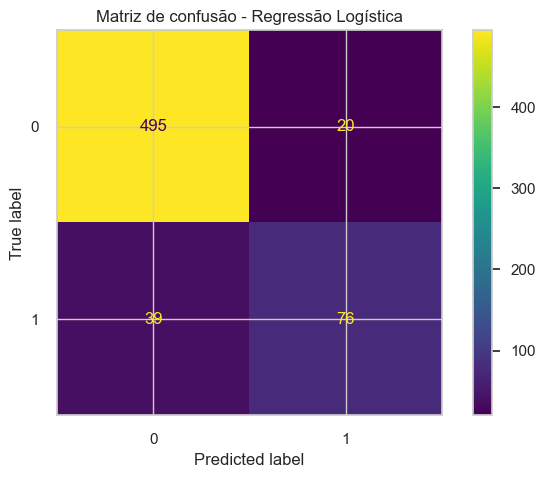

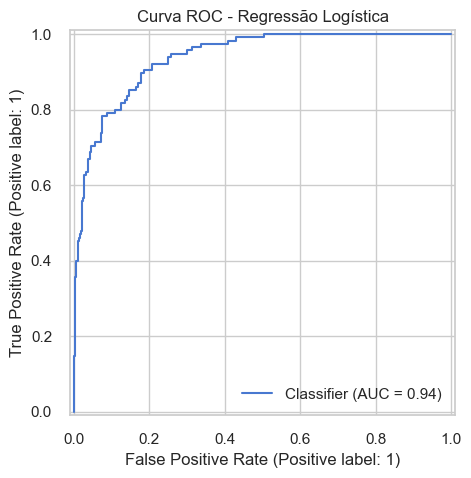

In [33]:

cm_log = confusion_matrix(y_cls_val, y_log_val_pred)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(values_format="d")
plt.title("Matriz de confusão - Regressão Logística")
plt.show()

RocCurveDisplay.from_predictions(y_cls_val, y_log_val_proba)
plt.title("Curva ROC - Regressão Logística")
plt.show()


## 7. Otimização de Modelos

In [34]:

# GridSearchCV para regressão polinomial com Ridge
from sklearn.linear_model import Ridge

param_grid_reg = {
    "poly__degree": [1, 2, 3],
    "ridge__alpha": [0.1, 1.0, 10.0]
}

ridge_poly_pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

grid_reg = GridSearchCV(
    ridge_poly_pipeline,
    param_grid=param_grid_reg,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_reg.fit(X_train[poly_features], y_reg_train)

print("Melhores parâmetros (Regressão):", grid_reg.best_params_)
print("Melhor score CV (neg RMSE):", grid_reg.best_score_)

best_reg_model = grid_reg.best_estimator_
y_reg_val_pred_gs = best_reg_model.predict(X_val[poly_features])

mae_gs = mean_absolute_error(y_reg_val, y_reg_val_pred_gs)
rmse_gs = mean_squared_error(y_reg_val, y_reg_val_pred_gs, squared=False)
r2_gs = r2_score(y_reg_val, y_reg_val_pred_gs)

print("\nDesempenho modelo otimizado (validação):")
print(f"MAE  = {mae_gs:.3f}")
print(f"RMSE = {rmse_gs:.3f}")
print(f"R^2  = {r2_gs:.3f}")


Melhores parâmetros (Regressão): {'poly__degree': 1, 'ridge__alpha': 1.0}
Melhor score CV (neg RMSE): -16.048489703135367

Desempenho modelo otimizado (validação):
MAE  = 13.015
RMSE = 16.028
R^2  = 0.169


In [35]:

# RandomizedSearchCV para Regressão Logística
param_dist_log = {
    "logreg__C": np.logspace(-3, 2, 10),
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "liblinear"]
}

rand_log = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=param_dist_log,
    n_iter=15,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

rand_log.fit(X_train, y_cls_train)

print("Melhores parâmetros (Logistic Regression):", rand_log.best_params_)
print("Melhor score CV (F1):", rand_log.best_score_)

best_log_model = rand_log.best_estimator_
y_log_val_proba_gs = best_log_model.predict_proba(X_val)[:, 1]
y_log_val_pred_gs = (y_log_val_proba_gs >= 0.5).astype(int)

acc_gs, prec_gs, rec_gs, f1_gs, auc_gs = classification_metrics(
    y_cls_val, y_log_val_pred_gs, y_log_val_proba_gs
)

print("\nDesempenho modelo otimizado (validação):")
print(f"Acurácia  = {acc_gs:.3f}")
print(f"Precisão  = {prec_gs:.3f}")
print(f"Recall    = {rec_gs:.3f}")
print(f"F1        = {f1_gs:.3f}")
print(f"AUC-ROC   = {auc_gs:.3f}")


Melhores parâmetros (Logistic Regression): {'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__C': 2.1544346900318843}
Melhor score CV (F1): 0.6775447789241896

Desempenho modelo otimizado (validação):
Acurácia  = 0.906
Precisão  = 0.792
Recall    = 0.661
F1        = 0.720
AUC-ROC   = 0.938


In [37]:

# PyCaret - Regressão
reg_exp = reg_setup(
    data=reg_setup_df,
    target="final_exam_score",
    session_id=42,
    train_size=0.7
)

best_reg_pycaret = reg_compare(sort="RMSE")
reg_results = reg_pull()
reg_results.head()



,Description,Value
0,Session id,42
1,Target,final_exam_score
2,Target type,Regression
3,Original data shape,"(3000, 23)"
4,Transformed data shape,"(3000, 23)"
5,Transformed train set shape,"(2100, 23)"
6,Transformed test set shape,"(900, 23)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,7.3553,83.8045,9.1507,0.7186,0.3727,0.4443,0.0080
ridge,Ridge Regression,7.3544,83.8077,9.1509,0.7186,0.3726,0.4439,0.0080
lr,Linear Regression,7.3545,83.8177,9.1514,0.7185,0.3725,0.4436,0.1690
lar,Least Angle Regression,7.3552,83.8322,9.1522,0.7185,0.3725,0.4436,0.0080
huber,Huber Regressor,7.5424,86.6047,9.2999,0.7094,0.3731,0.4462,0.0150
gbr,Gradient Boosting Regressor,7.5488,88.1792,9.3873,0.7036,0.3777,0.4312,0.0360
lightgbm,Light Gradient Boosting Machine,7.5885,91.5891,9.5679,0.6922,0.3779,0.4253,0.0530
rf,Random Forest Regressor,7.7658,94.6338,9.7250,0.6822,0.3868,0.4517,0.1460
et,Extra Trees Regressor,7.7618,95.5206,9.7709,0.6798,0.3878,0.4549,0.1170
llar,Lasso Least Angle Regression,7.9315,96.1346,9.7998,0.6785,0.3922,0.4827,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,7.3553,83.8045,9.1507,0.7186,0.3727,0.4443,0.008
ridge,Ridge Regression,7.3544,83.8077,9.1509,0.7186,0.3726,0.4439,0.008
lr,Linear Regression,7.3545,83.8177,9.1514,0.7185,0.3725,0.4436,0.169
lar,Least Angle Regression,7.3552,83.8322,9.1522,0.7185,0.3725,0.4436,0.008
huber,Huber Regressor,7.5424,86.6047,9.2999,0.7094,0.3731,0.4462,0.015


In [38]:

tuned_reg_pycaret = reg_tune(best_reg_pycaret)
tuned_reg_results = reg_pull()
tuned_reg_results.head()


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8036,73.1597,8.5533,0.7356,0.3260,0.4333
1,7.2623,80.2242,8.9568,0.7454,0.4016,0.2319
2,7.8428,91.6325,9.5725,0.6328,0.3501,0.4420
3,7.2746,84.3147,9.1823,0.7224,0.2923,0.2401
4,7.4036,84.8417,9.2110,0.7120,0.4900,1.4347
5,7.4590,84.6519,9.2006,0.7335,0.4533,0.3297
6,7.0604,79.8679,8.9369,0.7197,0.3384,0.3492
7,7.5979,86.4027,9.2953,0.7571,0.3827,0.2894
8,7.3947,85.9828,9.2727,0.7204,0.3519,0.3868


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8036,73.1597,8.5533,0.7356,0.3260,0.4333
1,7.2623,80.2242,8.9568,0.7454,0.4016,0.2319
2,7.8428,91.6325,9.5725,0.6328,0.3501,0.4420
3,7.2746,84.3147,9.1823,0.7224,0.2923,0.2401
4,7.4036,84.8417,9.2110,0.7120,0.4900,1.4347


In [40]:
# PyCaret - Classificação
cls_setup_df = df_model.copy()

cls_exp = cls_setup(
    data=cls_setup_df,
    target="passed_exam",
    session_id=42,
    train_size=0.7
)

best_cls_pycaret = cls_compare(sort="F1")
cls_results = cls_pull()
cls_results.head()


,Description,Value
0,Session id,42
1,Target,passed_exam
2,Target type,Binary
3,Original data shape,"(3000, 23)"
4,Transformed data shape,"(3000, 23)"
5,Transformed train set shape,"(2100, 23)"
6,Transformed test set shape,"(900, 23)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0070
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0490
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0100
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0320
lightgbm,Light Gradient Boosting Machine,0.9981,1.0000,0.9919,0.9974,0.9946,0.9934,0.9935,0.0420
lr,Logistic Regression,0.9976,1.0000,0.9947,0.9922,0.9933,0.9919,0.9919,0.0310
knn,K Neighbors Classifier,0.9776,0.9952,0.9194,0.9558,0.9361,0.9226,0.9236,0.0100
et,Extra Trees Classifier,0.9576,0.9931,0.7850,0.9713,0.8666,0.8418,0.8496,0.0430
lda,Linear Discriminant Analysis,0.9400,0.9833,0.7823,0.8712,0.8218,0.7860,0.7893,0.0090
nb,Naive Bayes,0.9243,0.9755,0.8499,0.7553,0.7981,0.7518,0.7551,0.0080


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.007
rf,Random Forest Classifier,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.049
ada,Ada Boost Classifier,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.010
gbc,Gradient Boosting Classifier,1.0000,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,0.032
lightgbm,Light Gradient Boosting Machine,0.9981,1.0,0.9919,0.9974,0.9946,0.9934,0.9935,0.042


In [41]:

tuned_cls_pycaret = cls_tune(best_cls_pycaret)
tuned_cls_results = cls_pull()
tuned_cls_results.head()


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 8. Avaliação Final em Conjunto de Teste

In [42]:

# Regressão – teste
y_reg_test_pred = best_reg_model.predict(X_test[poly_features])

test_reg_mae = mean_absolute_error(y_reg_test, y_reg_test_pred)
test_reg_rmse = mean_squared_error(y_reg_test, y_reg_test_pred, squared=False)
test_reg_r2 = r2_score(y_reg_test, y_reg_test_pred)

print("Desempenho final - Regressão (teste):")
print(f"MAE  = {test_reg_mae:.3f}")
print(f"RMSE = {test_reg_rmse:.3f}")
print(f"R^2  = {test_reg_r2:.3f}")


Desempenho final - Regressão (teste):
MAE  = 13.452
RMSE = 16.493
R^2  = 0.103


In [43]:

# Classificação – teste
y_cls_test_proba = best_log_model.predict_proba(X_test)[:, 1]
y_cls_test_pred = (y_cls_test_proba >= 0.5).astype(int)

test_acc, test_prec, test_rec, test_f1, test_auc = classification_metrics(
    y_cls_test, y_cls_test_pred, y_cls_test_proba
)

print("Desempenho final - Classificação (teste):")
print(f"Acurácia  = {test_acc:.3f}")
print(f"Precisão  = {test_prec:.3f}")
print(f"Recall    = {test_rec:.3f}")
print(f"F1        = {test_f1:.3f}")
print(f"AUC-ROC   = {test_auc:.3f}")


Desempenho final - Classificação (teste):
Acurácia  = 0.902
Precisão  = 0.800
Recall    = 0.627
F1        = 0.703
AUC-ROC   = 0.928


Variáveis com coeficientes positivos aumentam a chance de aprovação, como número de projetos concluídos, quantidade de exercícios práticos resolvidos e horas de estudo semanal — evidenciando que esforço e prática têm forte impacto no sucesso. Já coeficientes negativos indicam fatores que reduzem essa probabilidade ou são substitutos de baixa preparação. Esse tipo de interpretação é útil para identificar quais aspectos do comportamento do aluno mais contribuem para bons resultados.

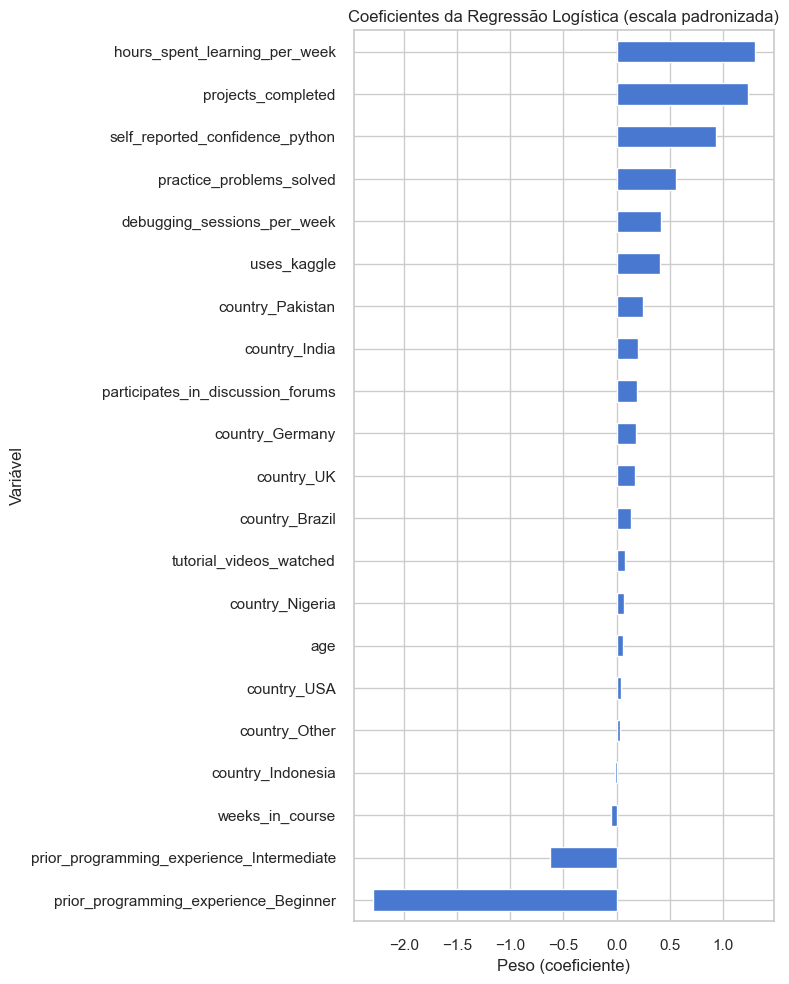

In [48]:
# Coeficientes da regressão logística
logreg = logreg_pipeline.named_steps["logreg"]

coef_series = pd.Series(
    logreg.coef_[0],
    index=X_train.columns
).sort_values()

plt.figure(figsize=(8, 10))
coef_series.plot(kind="barh")
plt.title("Coeficientes da Regressão Logística (escala padronizada)")
plt.xlabel("Peso (coeficiente)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()



## 9. Conclusões, Limitações e Próximos Passos

(Preencher com seu texto de análise, comparando baselines, modelos, tuning, etc.)

## 10. Referências

- pandas: https://pandas.pydata.org  
- seaborn: https://seaborn.pydata.org  
- statsmodels: https://www.statsmodels.org  
- scikit-learn: https://scikit-learn.org  
- PyCaret: https://pycaret.org  
- Dataset: *Python Learning & Exam Performance Dataset*, Kaggle  
